In [1]:
import os
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
sys.path.append('../src')
sys.path.append('../../src')
from Library import VerboseLibrary
from ActivityClassifier import PatientTrendAwareThresholder
import matplotlib.colors as mcolors

named_colors = list(mcolors.TABLEAU_COLORS)

device = 'cpu'#torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load Models

In [2]:
model_names = sorted(os.listdir('./models_no_thresholding'))
len(model_names)

10

In [3]:
model_coefficient_history = {}
model_coefficient_mask = {}
model_coefficients = {}

for name in tqdm(model_names):
    model = torch.load(os.path.join('.', 'models_no_thresholding', name)).to(device)
    model_coefficient_history[name] = np.array(model.coefficient_history)
    model_coefficients[name] = np.array(model.coefficient_mask.detach().cpu().numpy() * model.coefficients.detach().cpu().numpy())
    model_coefficient_mask[name] = np.array(model.coefficient_mask)

100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


# Coefficients

In [4]:
masked_coefficient_list = np.array([model_coefficients[name].round(2) for name in model_names], dtype=object)

In [5]:
masked_coefficient_list[masked_coefficient_list == 0] = '-'

In [6]:
pd.DataFrame(masked_coefficient_list[:, :, 0], columns=['*'.join(l) for l in VerboseLibrary(model.library).build_verbose()])

1   z_1 dz_1/dt z_1*z_1 z_1*dz_1/dt dz_1/dt*dz_1/dt z_1*z_1*z_1  \
0 -0.16 -0.19       -    0.37           -           -0.19        0.19   
1  0.25  -0.2       -   -0.06           -           -0.05        0.03   
2  0.08 -0.33       -   -0.03           -            0.03        0.01   
3  0.16 -0.07       -   -0.04           -               -       -0.01   
4   0.2 -0.11       -   -0.06           -           -0.09        0.08   
5  0.02 -0.08       -   -0.05           -            0.07        0.06   
6  0.11 -0.43       -   -0.13           -            0.13        0.02   
7  0.27 -0.14       -   -0.15           -            0.07        0.02   
8  0.36 -0.52       -   -0.08           -           -0.01        0.03   
9  0.18 -0.06       -   -0.08           -           -0.01        0.05   

  z_1*z_1*dz_1/dt z_1*dz_1/dt*dz_1/dt dz_1/dt*dz_1/dt*dz_1/dt sin(z_1)  \
0           -0.01                 0.4                    0.01    -0.58   
1               -               -0.03                       -    -0.77   
2               -               -0.04                       -    -0.74   
3               -               -0.02                       -    -0.98   
4               -               -0.12                       -     -0.8   
5            0.01               -0.09                       -    -0.86   
6               -                0.05                       -    -0.59   
7               -                0.06                       -    -0.84   
8               -                0.05                       -    -0.47   
9               -                   -                       -    -0.86   

  sin(dz_1/dt)  
0            -  
1            -  
2            -  
3            -  
4            -  
5            -  
6            -  
7            -  
8            -  
9            -

# Execute

In [7]:
threshold_trial_epochs = np.arange(0, 5001, 500)

In [8]:
model_sin_detected = {name: (np.abs(model_coefficient_history[name][threshold_trial_epochs, 10, 0]) >= 0.1).all() for name in model_names}
model_any_detected = {
    name: np.array([(np.abs(model_coefficient_history[name][threshold_trial_epochs, i, 0]) >= 0.1).all() for i in range(12) if i != 10]).any() 
    and (np.abs(model_coefficient_history[name][threshold_trial_epochs, 10, 0]) < 0.1).any()
    for name in model_names
}
model_none_detected = {name: np.array([(np.abs(model_coefficient_history[name][threshold_trial_epochs, i, 0]) < 0.1).any() for i in range(12)]).all() for name in model_names}

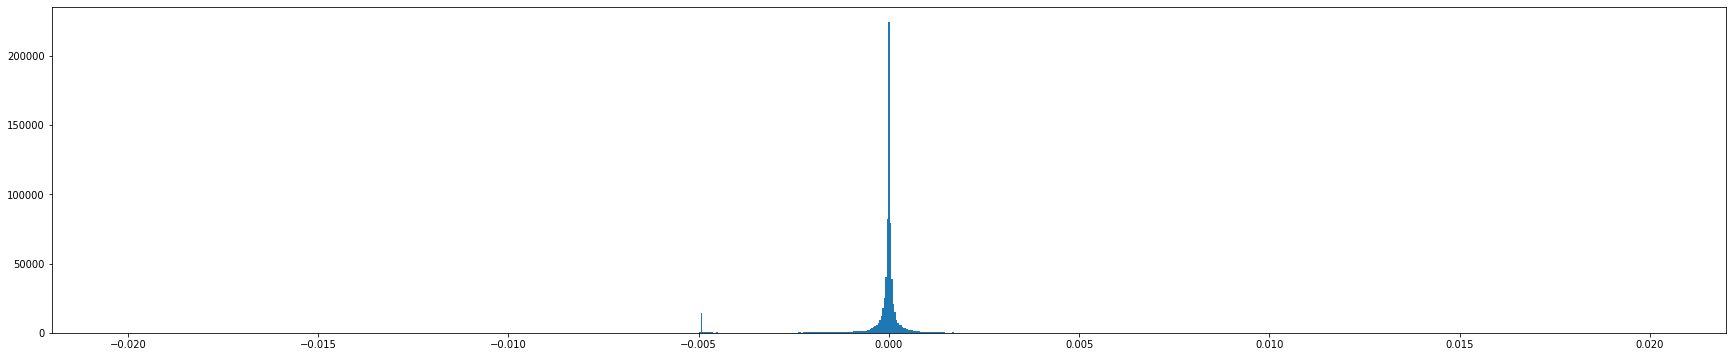

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(30, 6))
ax.hist(np.stack([np.diff(model_coefficient_history[name], axis=0) for name in model_names]).flatten(), bins=np.linspace(-0.02, 0.02, 1000));

In [10]:
trend_std = 2 * np.stack([model_coefficient_history[name] for name in model_names]).flatten().std()
trend_std.round(4)

0.501

In [11]:
trend_std = 2 * np.stack([np.diff(model_coefficient_history[name], axis=0) for name in model_names]).flatten().std()
trend_std.round(4)

0.002

In [12]:
cc = PatientTrendAwareThresholder()

In [13]:
model_classified_history = {}
model_classified_plus_history = {}

for name in tqdm(model_names):
    model_classified_history[name] = np.stack([cc.classify_converged(model_coefficient_history[name][:i])[0] for i in range(1, len(model_coefficient_history[name]))])

100%|██████████| 10/10 [00:01<00:00,  9.81it/s]


In [37]:
def coefficient_survived(name, i, dim, genuine=False):
    if not genuine:
        return np.logical_not(model_classified_history[name][:5001, i, dim]).all()
    else:
        return np.logical_not(model_classified_history[name][:5001, i, dim]).all() and np.abs(model_coefficients[name][i, dim]) >= 0.1

In [51]:
model_ptct_sin_detected = {name: coefficient_survived(name, 10, 0) for name in model_names}
model_ptct_any_detected = {
    name: np.array([coefficient_survived(name, i, 0) for i in range(12) if i != 10]).any() 
    and not model_ptct_sin_detected[name]
    for name in model_names
}
model_ptct_none_detected = {name: not np.array([coefficient_survived(name, i, 0) for i in range(12)]).any() for name in model_names}

In [52]:
model_genuine_ptct_sin_detected = {name: coefficient_survived(name, 10, 0, genuine=True) for name in model_names}
model_genuine_ptct_any_detected = {
    name: np.array([coefficient_survived(name, i, 0, genuine=True) for i in range(12) if i != 10]).any() 
    and not model_genuine_ptct_sin_detected[name]
    for name in model_names
}
model_genuine_ptct_none_detected = {name: not np.array([coefficient_survived(name, i, 0, genuine=True) for i in range(12)]).any() for name in model_names}

In [53]:
# with non-genuine
np.sum([model_ptct_sin_detected[name] for name in model_names]), np.sum([model_ptct_any_detected[name] for name in model_names]), np.sum([model_ptct_none_detected[name] for name in model_names])

(10, 0, 0)

In [54]:
# without non-genuine
np.sum([model_genuine_ptct_sin_detected[name] for name in model_names]), np.sum([model_genuine_ptct_any_detected[name] for name in model_names]), np.sum([model_genuine_ptct_none_detected[name] for name in model_names])

(10, 0, 0)

In [44]:
total_terms_detected = {name: np.sum(np.logical_not(model_classified_history[name][:5001, :, 0]).all(axis=0)) for name in model_names}
total_genuine_terms_detected = {name: np.sum(np.logical_and(np.abs(model_coefficient_history[name][5001, :, 0]) >= 0.1, np.logical_not(model_classified_history[name][:5001, :, 0]).all(axis=0))) for name in model_names}

In [45]:
np.mean([v for v in total_terms_detected.values()]), np.mean([v for v in total_genuine_terms_detected.values()])

(3.7, 3.2)

# History

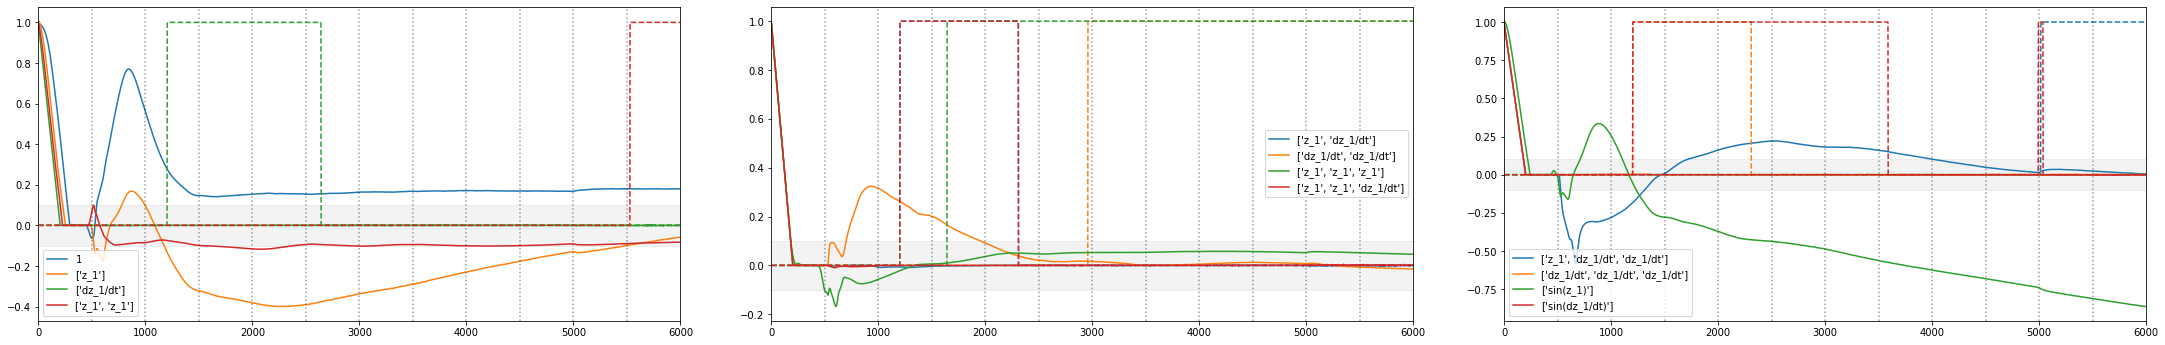

In [58]:
m = model_names[-1]
xlim = 6000

fig, ax = plt.subplots(1, 3, figsize=(30, 5))
fig.tight_layout(w_pad=6, h_pad=5)
plt.subplots_adjust(top=0.95)

for split in range(3):
    for i, (n, c, r) in enumerate(
        zip(VerboseLibrary(model.library).build_verbose()[split*4:(split+1)*4],
        model_coefficient_history[m].squeeze().T[split*4:(split+1)*4],
        model_classified_history[m].squeeze().T[split*4:(split+1)*4],
        )):
        ax[split].plot(c[:xlim], label=n, color=named_colors[i])
        ax[split].plot(r[:xlim], color=named_colors[i], linestyle='--')
        ax[split].legend(); ax[split].axhspan(-0.1, 0.1, color='black', alpha=0.01); ax[split].set_xlim(0, xlim);# ax[split].set_ylim(-0.1, 0.1)
        for threshold_epoch in np.arange(500, xlim, 500): ax[split].axvline(threshold_epoch, color='black', alpha=0.1, linestyle=':')

# Histories with Thresholding in Epoch 500

In [40]:
model_thresholded_history = {name: model_coefficient_history[name][:, np.abs(model_coefficient_history[name][500, :, 0]) < 0.1, 0] for name in model_names}
model_survived_history = {name: model_coefficient_history[name][:, np.abs(model_coefficient_history[name][500, :, 0]) >= 0.1, 0] for name in model_names}

In [41]:
model_sin_history = {name: model_coefficient_history[name][:, 10, 0] for name in model_names}
model_other_history = {name: model_coefficient_history[name][:, [i for i in range(12) if i != 10], 0] for name in model_names}

100%|██████████| 10/10 [00:00<00:00, 209.39it/s]


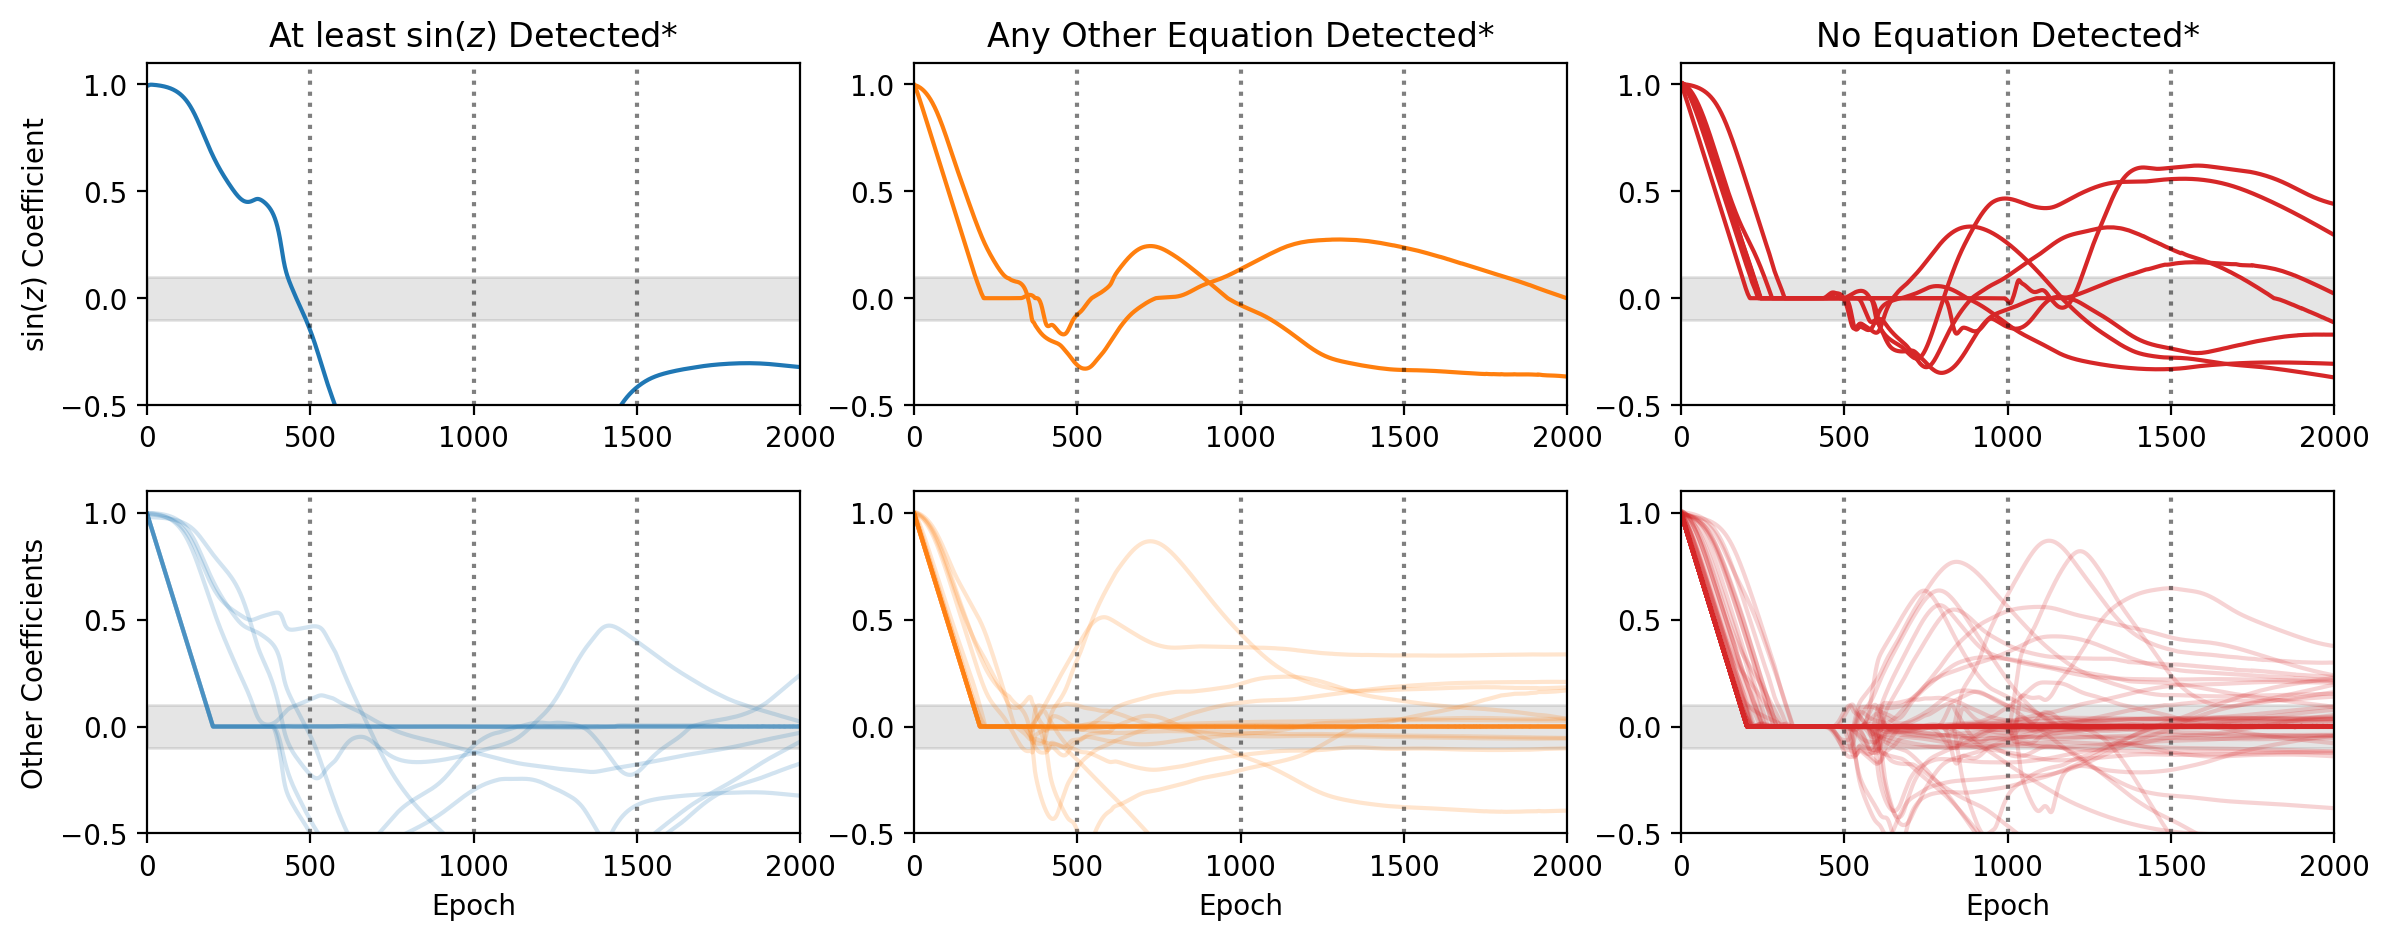

In [42]:
fig, axes = plt.subplots(2, 3, figsize=(21/1.8, 8/1.8), dpi=200)
fig.tight_layout(w_pad=1, h_pad=1)
xlim = 2000

for name in tqdm(model_names):
    if model_sin_detected[name]:
        axes[0][0].plot(model_sin_history[name][:xlim], color='tab:blue');
        axes[1][0].plot(model_other_history[name][:xlim], color='tab:blue', alpha=0.2);
    if model_any_detected[name]:
        axes[0][1].plot(model_sin_history[name][:xlim], color='tab:orange');
        axes[1][1].plot(model_other_history[name][:xlim], color='tab:orange', alpha=0.2);
    if model_none_detected[name]:
        axes[0][2].plot(model_sin_history[name][:xlim], color='tab:red');
        axes[1][2].plot(model_other_history[name][:xlim], color='tab:red', alpha=0.2);

axes[0][0].set_title(f'At least $\sin(z)$ Detected*');
axes[0][1].set_title(f'Any Other Equation Detected*');
axes[0][2].set_title(f'No Equation Detected*');

axes[0][0].set_ylabel(r'$\sin(z)$ Coefficient');
axes[1][0].set_ylabel('Other Coefficients');

for ax in axes[0]:
    ax.set_xlim(0, xlim); ax.axhspan(-0.1, 0.1, color='black', alpha=0.1);
    for threshold_epoch in np.arange(500, xlim, 500): ax.axvline(threshold_epoch, color='black', alpha=0.5, linestyle=':'); ax.set_ylim(-0.5, 1.1)

for ax in axes[1]:
    ax.set_xlabel('Epoch'); ax.set_xlim(0, xlim); ax.axhspan(-0.1, 0.1, color='black', alpha=0.1);
    for threshold_epoch in np.arange(500, xlim, 500): ax.axvline(threshold_epoch, color='black', alpha=0.5, linestyle=':'); ax.set_ylim(-0.5, 1.1)

In [43]:
confusion_matrix = np.zeros((3, 3))

for name in model_names:
    confusion_matrix[int(model_ptct_any_detected[name]) + 2 * int(model_ptct_none_detected[name]), int(model_any_detected[name]) + 2 * int(model_none_detected[name])] += 1

pd.DataFrame(confusion_matrix, columns=['ST Sin', 'ST Any', 'ST None'], index=['PTAT Sin', 'PTAT Any', 'PTAT None'])

ST Sin  ST Any  ST None
PTAT Sin      1.0     2.0      7.0
PTAT Any      0.0     0.0      0.0
PTAT None     0.0     0.0      0.0

In [36]:
model_coefficients[model_names[0]][10]

array([-0.5816872], dtype=float32)

In [44]:
#[[TN, FP]
# [FN, TP]]

sin_confusion_matrix = np.zeros((2, 2))
any_confusion_matrix = np.zeros((2, 2))
none_confusion_matrix = np.zeros((2, 2))

for name in model_names:
    sin_confusion_matrix[int(model_ptct_sin_detected[name]), int(model_sin_detected[name])] += 1
    any_confusion_matrix[int(model_ptct_any_detected[name]), int(model_any_detected[name])] += 1
    none_confusion_matrix[int(model_ptct_none_detected[name]), int(model_none_detected[name])] += 1

In [45]:
print('Sin Detected')
pd.DataFrame(sin_confusion_matrix, columns=['ST No', 'ST Yes'], index=['PTAT No', 'PTAT Yes'])

Sin Detected


ST No  ST Yes
PTAT No     0.0     0.0
PTAT Yes    9.0     1.0

In [19]:
print('Any Other Equation Detected')
pd.DataFrame(any_confusion_matrix, columns=['ST No', 'ST Yes'], index=['PTAT No', 'PTAT Yes'])

Any Other Equation Detected


ST No  ST Yes
PTAT No     8.0     2.0
PTAT Yes    0.0     0.0

In [20]:
print('No Equation Detected')
pd.DataFrame(none_confusion_matrix, columns=['ST No', 'ST Yes'], index=['PTAT No', 'PTAT Yes'])

No Equation Detected


ST No  ST Yes
PTAT No     3.0     7.0
PTAT Yes    0.0     0.0